In [1]:
from wobble.interp import interp
import h5py
import wobble
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
starid = 'hip54287'
filename = '../data/'+starid+'_e2ds.hdf5'

In [3]:
with h5py.File(filename) as f:
    data = np.log(f['data'][30])
    data_xs = np.log(f['xs'][30])
    ivars = np.copy(f['ivars'][30])
    pipeline_rvs = -1. * np.copy(f['pipeline_rvs'])

In [4]:
for n in range(len(data)):
    data[n] -= wobble.fit_continuum(data_xs[n], data[n], ivars[n])

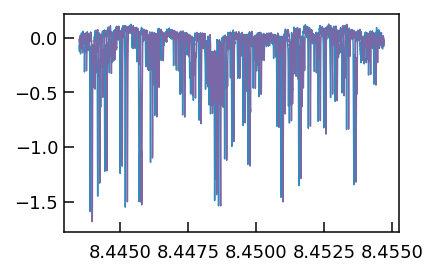

In [5]:
plt.plot(data_xs[0], data[0])
plt.plot(data_xs[5], data[5])

In [6]:
len(data)

75

In [7]:
a = wobble.star(starid+'_e2ds.hdf5', orders=[30])
a.initialize_model(0, 'star')
model_xs, model_ys = a.model_xs_star[0], a.model_ys_star[0]

initializing star model...


In [8]:
np.shape(model_xs)

(6815,)

In [9]:
import tensorflow as tf

In [10]:
T = tf.float64
model_xs_tensor = tf.constant(model_xs, dtype=T)
model_ys_tensor = tf.Variable(model_ys, dtype=T)
data_tensor = tf.constant(data, dtype=T)
xs_tensor = tf.constant(data_xs, dtype=T)
ivars_tensor = tf.constant(ivars, dtype=T)

In [11]:
rvs_tensor = tf.Variable(pipeline_rvs, dtype=T)

In [12]:
c = 2.99792458e8   # m/s

def doppler(v):
    frac = (1. - v/c) / (1. + v/c)
    return tf.sqrt(frac)

In [13]:
nll = tf.constant(0.0, dtype=T)
for n in range(len(data)):
    shifted_xs = xs_tensor[n] + tf.log(doppler(rvs_tensor[n]))
    model = interp(shifted_xs, model_xs_tensor, model_ys_tensor)
    nll += 0.5*tf.reduce_sum((data_tensor - model)**2 * ivars_tensor[n])
    
grad_model = tf.gradients(nll, [model_ys_tensor])
grad_rvs = tf.gradients(nll, [rvs_tensor])

In [14]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    print "one"
    g_model = session.run(grad_model)
    print "two"
    g_rvs = session.run(grad_rvs)
    print "three"
    g_model = session.run(grad_model)
    print "four"
    g_rvs = session.run(grad_rvs)
    print "five"

one
two
three
four
five


In [17]:
print g_model
g_model_tensor = tf.gather(g_model[0].values, g_model[0].indices)
print g_model_tensor

[IndexedSlicesValue(values=array([ 86292.28397447, 140536.86099033, 130598.74316256, ...,
            0.        ,      0.        ,      0.        ]), indices=array([  71,   73,   75, ..., 6812, 6813, 6814]), dense_shape=array([6815], dtype=int32))]
Tensor("Gather_227:0", shape=(2351700,), dtype=float64)


In [96]:
dense = np.zeros(g_model[0].dense_shape[0])
slices = g_model[0]
for i, v in zip(slices.indices, slices.values):
    print i, v
    dense[i] = np.copy(slices.values)
print np.min(slices.indices), np.max(slices.indices)
print np.shape(dense)

0 6814
(6815,)


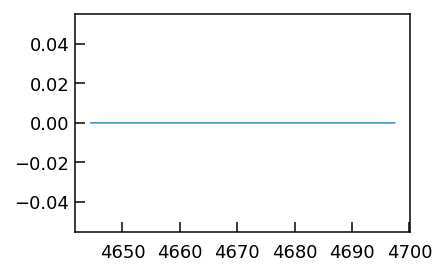

In [97]:
plt.step(np.exp(model_xs), dense)

In [19]:
g_model_dense = tf.sparse_to_dense(g_model[0].indices, g_model[0].dense_shape, g_model[0].values)
print g_model_dense
print g_model_dense.get_shape()
print g_model_dense.eval()

Tensor("SparseToDense_1:0", shape=(6815,), dtype=float64)
(6815,)


ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`

In [54]:
with tf.Session() as session:
    print g_model_dense.eval()

InvalidArgumentError: indices[4096] = [0] is out of order
	 [[Node: SparseToDense_11 = SparseToDense[T=DT_DOUBLE, Tindices=DT_INT64, validate_indices=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](SparseToDense_11/sparse_indices, SparseToDense_11/output_shape, SparseToDense_11/sparse_values, SparseToDense_11/default_value)]]

Caused by op u'SparseToDense_11', defined at:
  File "/usr/local/Cellar/python/2.7.13/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/local/Cellar/python/2.7.13/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-53-dbfd51cbbae3>", line 1, in <module>
    g_model_dense = tf.sparse_to_dense(g_model[0].indices, g_model[0].dense_shape, g_model[0].values)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/ops/sparse_ops.py", line 757, in sparse_to_dense
    name=name)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/ops/gen_sparse_ops.py", line 1896, in _sparse_to_dense
    name=name)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): indices[4096] = [0] is out of order
	 [[Node: SparseToDense_11 = SparseToDense[T=DT_DOUBLE, Tindices=DT_INT64, validate_indices=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](SparseToDense_11/sparse_indices, SparseToDense_11/output_shape, SparseToDense_11/sparse_values, SparseToDense_11/default_value)]]


AttributeError: 'Tensor' object has no attribute 'ndim'

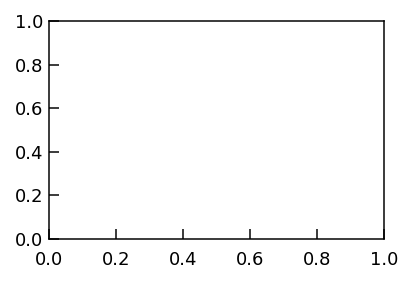

In [41]:
plt.plot(model_xs, g_model_dense)

In [27]:
np.shape(g_model[0])

(3,)